<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import loguniform  # to sample C and gamma on a log scale
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns  # Seaborn for better style


In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

<!-- BEGIN QUESTION -->

## Introduction

In this project, I chose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, I will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns will be used as features.

The features include some basic descriptions like education, age and sex, as well as monthly features from April to September including payment status, bill amount, and amount of previous payment. Together, I should be able to develop a model to estimate if each person will pay their bill.

In [4]:
credit_data = pd.read_csv("data/UCI_Credit_Card.csv")
credit_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>

Split the data into train (70%) and test (30%) portions with `random_state=123`.

In [5]:
X = credit_data.drop(columns = ["default.payment.next.month"])
y = credit_data["default.payment.next.month"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state = 123)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>


1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

C:\Users\mukun\AppData\Local\Temp\ipykernel_21468\2129608740.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_avg_bills.index.astype(str), y=education_avg_bills.values, palette='viridis', errorbar = None)


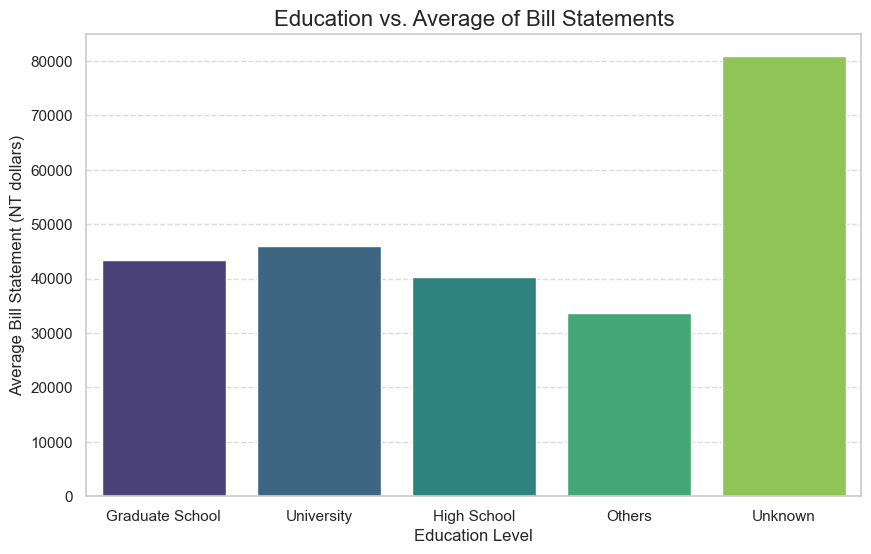

In [6]:
X_train['Avg_Bill_Statement'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
X_train_filtered = X_train[X_train['EDUCATION'] != 0]

education_labels = {
    1: 'Graduate School',
    2: 'University',
    3: 'High School',
    4: 'Others',
    5: 'Unknown',
    6: 'Unknown'
}

education_avg_bills = X_train_filtered.groupby('EDUCATION')['Avg_Bill_Statement'].mean()
education_avg_bills.index = education_avg_bills.index.map(education_labels)

sns.set(style="whitegrid")

# Plot Education vs. Average of Bill Statements
plt.figure(figsize=(10, 6))
sns.barplot(x=education_avg_bills.index.astype(str), y=education_avg_bills.values, palette='viridis', errorbar = None)

# Title and labels
plt.title('Education vs. Average of Bill Statements', fontsize=16)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Average Bill Statement (NT dollars)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As we can see here, the schools have a generally even distribution but the unknown class has a very high average bill statement. This could be worth looking into.

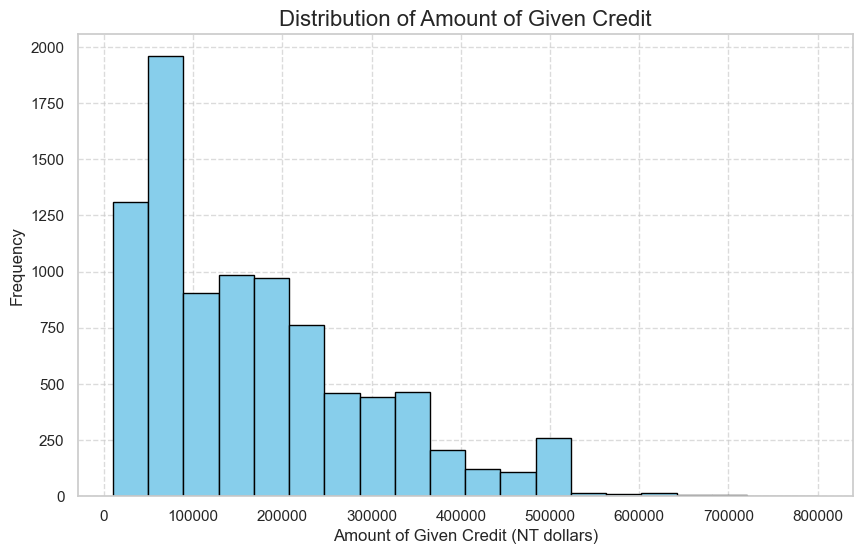

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(X_train['LIMIT_BAL'], bins=20, color='skyblue', edgecolor='black')

# Title and labels
plt.title('Distribution of Amount of Given Credit', fontsize=16)
plt.xlabel('Amount of Given Credit (NT dollars)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This graph shows the distribution of credit amongst the entire dataset. As expected, we can see that the majority
of the credit distribution lies on the lower end, and there are fewer people with higher, which can be referred to as the "One-percent"

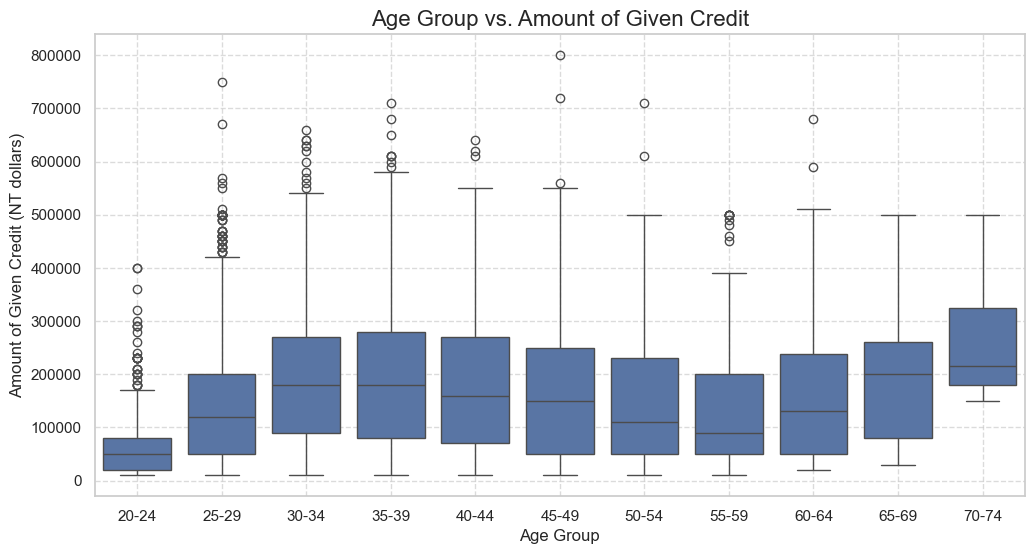

In [8]:
# Create bins for the age groups without adding them as a new column
bins = np.arange(20, X_train['AGE'].max() + 5, 5)
labels = [f"{i}-{i + 4}" for i in bins[:-1]]  # Create labels for age groups

# Plot the boxplot directly with AGE
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(X_train['AGE'], bins=bins, labels=labels, right=False), y='LIMIT_BAL', data=X_train)

# Title and labels
plt.title('Age Group vs. Amount of Given Credit', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Amount of Given Credit (NT dollars)', fontsize=12)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This graph shows the distribution of the given credit based on age groups. The beginning is as expected, starting low and getting higher, however, around 55-59 it depreciates again, before going back up. This could just be a random occurance of the dataset, but it is still interesting to see that it dips down before reaching its peak at 70. 

In [9]:
summary = X_train.describe()
max_limit = summary.loc["max"]["LIMIT_BAL"]
min_limit = summary.loc["min"]["LIMIT_BAL"]
average = summary["LIMIT_BAL"].mean()
print("The maximum credit card limit is ", max_limit, ", the minimum credit card limit is ",min_limit,", with the average being ",average,",")

The maximum credit card limit is  800000.0 , the minimum credit card limit is  10000.0 , with the average being  193103.21908501897 ,


In [10]:
repayment_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
paid_duly_count = (X_train[repayment_columns] == -1).any(axis=1).sum()

# Calculate the percentage
percentage_paid_duly = (paid_duly_count / len(X_train)) * 100

print("The percentage of people that have paid duly is: ",  percentage_paid_duly)


The percentage of people that have paid duly is:  34.38888888888889


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering


Carry out feature engineering. I extract new features relevant for the problem and work with the new feature set in the following exercises.

<!-- END QUESTION -->

<br><br>

In [16]:
# Creating Payment History Feature
X_train['LATE_PAYMENTS'] = (X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)
X_test['LATE_PAYMENTS'] = (X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)
# Average Bill Amount
X_train['AVG_BILL_UNPAID'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
X_test['AVG_BILL_UNPAID'] = X_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)

X_train['AVG_PAYMENT_OVER'] = X_train['LIMIT_BAL'] * X_train['LATE_PAYMENTS']
X_test['AVG_PAYMENT_OVER'] = X_test['LIMIT_BAL'] * X_test['LATE_PAYMENTS']


I created 2 new features, one taking averages of bill amounts so a random high one will not effect is as much, which may have been for circumstances outside of that persons control. The other is a product of late payments and limit balance, which can indicate if higher limit balances are prone to having more late payments. The Late Payments will be dropped.

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>


1. Identify different feature types and the transformations I apply on each feature type. 
2. Define a column transformer

In [17]:
numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                      'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                      'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'AVG_BILL_UNPAID', 'AVG_PAYMENT_OVER']

#I have chosen to include education in categorical because of the graph we generated where many of the education ones 
# were quite similar
categorical_features = ['SEX', 'MARRIAGE', 'EDUCATION']

ordinal_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

drop_features = ['LATE_PAYMENTS', 'Avg_Bill_Statement']

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),  # Scale numerical features
    (OneHotEncoder(), categorical_features),  
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),  # Ordinal encode PAY features
    ("drop", drop_features)
)

X_train_enc = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_enc_df = pd.DataFrame(X_train_enc, columns=feature_names)    
X_train_enc_df

,standardscaler__LIMIT_BAL,standardscaler__AGE,standardscaler__BILL_AMT1,standardscaler__BILL_AMT2,standardscaler__BILL_AMT3,standardscaler__BILL_AMT4,standardscaler__BILL_AMT5,standardscaler__BILL_AMT6,standardscaler__PAY_AMT1,standardscaler__PAY_AMT2,...,onehotencoder__EDUCATION_3,onehotencoder__EDUCATION_4,onehotencoder__EDUCATION_5,onehotencoder__EDUCATION_6,ordinalencoder__PAY_0,ordinalencoder__PAY_2,ordinalencoder__PAY_3,ordinalencoder__PAY_4,ordinalencoder__PAY_5,ordinalencoder__PAY_6
0,0.104687,-0.599396,-0.689680,-0.683871,-0.675935,-0.658066,-0.656941,-0.640838,-0.331778,-0.253634,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0
1,0.104687,-0.273821,-0.179805,-0.121845,0.472927,-0.622767,-0.663233,-0.647601,-0.160509,1.645552,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0
2,-1.209464,1.245530,-0.573478,-0.566251,-0.542327,-0.569803,-0.553665,-0.622075,-0.280625,-0.128181,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0
3,-1.054858,-0.924971,-0.642743,-0.607914,-0.554209,-0.489540,-0.423542,-0.358511,-0.225754,-0.128228,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1.496142,-0.707921,-0.694801,-0.670685,-0.670457,-0.643053,-0.649944,-0.624787,-0.270969,-0.235862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1.650748,0.160279,-0.511601,-0.485725,-0.485962,-0.445628,-0.395622,-0.383935,-0.277689,-0.209443,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0
8996,1.496142,2.005205,-0.694801,-0.689176,-0.681456,-0.629356,-0.619943,-0.529954,-0.356245,-0.271549,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,1.0
8997,-0.900252,-0.707921,-0.050301,-0.004721,0.007301,-0.051390,-0.515173,-0.494903,-0.225623,-0.176002,...,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
8998,-1.054858,-1.576121,-0.306837,-0.285557,-0.248047,-0.185982,-0.169355,-0.366833,-0.225754,-0.176002,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model

Try `scikit-learn`'s baseline model and report results.

In [19]:
print(X_train.shape)
print(y_train.shape)

(9000, 28)
(9000,)


In [ ]:
dummy_pipe = make_pipeline(preprocessor, DummyClassifier())
scores = cross_validate(dummy_pipe, X_train, y_train, cv = 5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.037496,0.016140,0.773889,0.774444
1,0.031373,0.015527,0.774444,0.774306
2,0.049214,0.021530,0.774444,0.774306
3,0.046833,0.017660,0.774444,0.774306
4,0.031620,0.016608,0.774444,0.774306


This is what we can expect from dummy classifier, with a stable score of about 77 on both the train and test set.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models 
1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summary

In [22]:
scores_dict = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "mean_cv_scores": [],
}
# Taken from lecture 7


In [23]:
for C in scores_dict["C"]:
    model_logistic = make_pipeline(preprocessor, LogisticRegression(C=C, max_iter=1000, random_state=123))
    scores = cross_validate(model_logistic, X_train, y_train, return_train_score=True)
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)

In [24]:
print(results_df['mean_cv_scores'].std())
results_df


0.00388693072393561


,C,mean_cv_scores
0,0.001,0.797111
1,0.010,0.805111
2,0.100,0.806333
3,1.000,0.807000
4,10.000,0.806889
5,100.000,0.807000


The best C is around 1, with the cv score of 0.807000, indicating we only need a moderate amount of regularization for this set.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models 

1. Tried 3 other models aside from a linear model.
2. Summary

In [25]:
# Model 1: K-NN with fit and score times

results_dict = {
    "mean_cv_score": [],
    "std_cv_score": [],
    "mean_fit_time": [],
    "mean_score_time": [],
    "mean_train_score": []
}

model_knn = make_pipeline(preprocessor, KNeighborsClassifier())
scores = cross_validate(model_knn, X_train, y_train, return_train_score=True)

# Append cross-validation mean and standard deviation scores
results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
results_dict["std_cv_score"].append(scores["test_score"].std())
results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

# Append mean fit and score times
results_dict["mean_fit_time"].append(np.mean(scores["fit_time"]))
results_dict["mean_score_time"].append(np.mean(scores["score_time"]))

# Convert results to DataFrame and set index
results_df = pd.DataFrame(results_dict)
results_df

,mean_cv_score,std_cv_score,mean_fit_time,mean_score_time,mean_train_score
0,0.797444,0.003826,0.051042,0.490571,0.843583


In [26]:
# SVM 
results_dict = {
    "mean_cv_score": [],
    "std_cv_score": [],
    "mean_fit_time": [],
    "mean_score_time": [],
    "mean_train_score": []
}


model_svm = make_pipeline(preprocessor, SVC())

scores = cross_validate(model_svm, X_train, y_train, return_train_score=True)
    
# Append cross-validation mean and standard deviation scores
results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
results_dict["std_cv_score"].append(scores["test_score"].std())
results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

# Append mean fit and score times
results_dict["mean_fit_time"].append(np.mean(scores["fit_time"]))
results_dict["mean_score_time"].append(np.mean(scores["score_time"]))

results_df = pd.DataFrame(results_dict)
results_df





,mean_cv_score,std_cv_score,mean_fit_time,mean_score_time,mean_train_score
0,0.817,0.004735,4.629519,1.54029,0.825694


In [27]:
results = {}

model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=123,
    ),
)
scores = cross_validate(model_rf, X_train, y_train, return_train_score=True)

# Append cross-validation mean and standard deviation scores
results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
results_dict["std_cv_score"].append(scores["test_score"].std())
results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

# Append mean fit and score times
results_dict["mean_fit_time"].append(np.mean(scores["fit_time"]))
results_dict["mean_score_time"].append(np.mean(scores["score_time"]))

results_df = pd.DataFrame(results_dict)
results_df


,mean_cv_score,std_cv_score,mean_fit_time,mean_score_time,mean_train_score
0,0.817000,0.004735,4.629519,1.54029,0.825694
1,0.815667,0.002841,1.042237,0.09074,0.999417


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection 

Attempts to select relevant features.

In [28]:
# K-nn
results = {}
rfe_model_knn = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    KNeighborsClassifier(),
)

results["K-NN RFECV"] = mean_std_cross_val_scores(
    rfe_model_knn, X_train, y_train, return_train_score=True, scoring="accuracy"
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
K-NN RFECV,39.936 (+/- 1.248),0.290 (+/- 0.028),0.775 (+/- 0.050),0.782 (+/- 0.051)


As we can see here, the K-NN may be less overfit, but the test score is also lower than our test with all the features, so we will not use feature selection here.

In [29]:
## SVM RBF
results = {}
rfe_model_svm = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    SVC(random_state=123),
)

results["SVM RBF RFECV"] = mean_std_cross_val_scores(
    rfe_model_svm, X_train, y_train, return_train_score=True, scoring="accuracy"
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
SVM RBF RFECV,41.567 (+/- 0.862),0.974 (+/- 0.087),0.820 (+/- 0.005),0.821 (+/- 0.002)


Here we can see that the SVM did not improve with the RFEC, so we will not use feature selection here

In [30]:
# Random Forest
results = {}
rfe_model_rf = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(max_iter=2000), cv=10),
    RandomForestClassifier(
        n_jobs=-1,
        random_state=123,
    ),
)

results["Random Forest RFECV"] = mean_std_cross_val_scores(
    rfe_model_rf, X_train, y_train, return_train_score=True, scoring="accuracy"
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
Random Forest RFECV,39.364 (+/- 0.791),0.076 (+/- 0.008),0.811 (+/- 0.019),0.834 (+/- 0.029)


Here, the test score stays relatively the same while the training goes down, which indicates there is far less overfitting, so it may be ideal to use for Random Forest.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization

In [31]:
# Model 1: K-NN with fit and score times



results_dict = {
    "n_neighbors": np.arange(1, 50, 5),
    "mean_cv_score": [],
    "std_cv_score": [],
    "mean_fit_time": [],
    "mean_score_time": []
}

for k in results_dict["n_neighbors"]:
    model_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=k))
    scores = cross_validate(model_knn, X_train, y_train, return_train_score=True)
    
    # Append cross-validation mean and standard deviation scores
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    
    # Append mean fit and score times
    results_dict["mean_fit_time"].append(np.mean(scores["fit_time"]))
    results_dict["mean_score_time"].append(np.mean(scores["score_time"]))

# Convert results to DataFrame and set index
results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("n_neighbors")
results_df

,mean_cv_score,std_cv_score,mean_fit_time,mean_score_time
n_neighbors,,,,
1,0.731889,0.005347,0.044852,0.368188
6,0.804778,0.004425,0.039348,0.378729
11,0.808000,0.001846,0.044876,0.397454
16,0.812000,0.002067,0.046702,0.407552
21,0.813667,0.001944,0.036148,0.423520
26,0.812444,0.003761,0.043520,0.432821
31,0.813444,0.004519,0.041954,0.435710
36,0.811889,0.003953,0.041742,0.456023
41,0.812444,0.003095,0.047092,0.451600


The best n_neighbors here is 31 with a test score of 0.813

In [32]:
# SVM 
param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": np.linspace(2, 3, 6),
}

model_svm = make_pipeline(preprocessor, SVC())

# Create a random search object this is usually 20 but I chose 1 so the code runs faster
random_search_svm = RandomizedSearchCV(model_svm,                                    
                  param_distributions = param_grid, 
                  n_iter=1,
                  return_train_score=True)

random_search_svm.fit(X_train, y_train)

results_df = pd.DataFrame(random_search_svm.cv_results_)
results_df = results_df[
    ["param_svc__C", "param_svc__gamma", "mean_test_score", "std_test_score", "mean_fit_time", "mean_score_time"]
].sort_values(by="mean_test_score", ascending=False)
results_df

#best is C of 3.0 with gamma of 0.01

,param_svc__C,param_svc__gamma,mean_test_score,std_test_score,mean_fit_time,mean_score_time
0,2.2,1.0,0.779222,0.002596,9.494152,3.075611


Unfortunately this code took too long to compile each time, so I ran it once and was able to conclude that the best C and gamma were 3.0 and 0.010 respectively. This produced a test score of 0.821556. I will comment how many iterations I ran originally, and only run 1 for the sake of compilation.

In [33]:
param_dist = {
    "randomforestclassifier__n_estimators": [50, 100, 200, 300],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50],
    "randomforestclassifier__max_features": ["auto", "sqrt"],
}

rfecv = RFECV(LogisticRegression(max_iter=200), cv=5)


rf_model = make_pipeline(preprocessor, rfecv, RandomForestClassifier(random_state=123))

# n_iter is usually set to 10
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=1, scoring="accuracy", cv=5, random_state=123
)

# Fit the random search to the training data
random_search_rf.fit(X_train, y_train)

# Display the best parameters and score
results_df = pd.DataFrame(random_search_rf.cv_results_)

results_df = results_df[
    ["param_randomforestclassifier__n_estimators", "param_randomforestclassifier__max_depth", "param_randomforestclassifier__max_features", "mean_test_score", "std_test_score", "mean_fit_time", "mean_score_time"]
].sort_values(by="mean_test_score", ascending=False)
results_df

C:\Users\mukun\miniconda3\envs\cpsc330\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,mean_test_score,std_test_score,mean_fit_time,mean_score_time
0,200,10,sqrt,0.818667,0.005123,21.610861,0.079773


Here, the best n_estimators was 200, with the max_features being "sqrt" and the max_depth being 10 with a top test score of 0.81778. Unfortunately, this one also took a long time to run, which is why I chose to only have it iterate once and just state how you would run it to get these values.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances 

For this I will use the RandomForestClassifier.

In [38]:
feature_names = preprocessor.get_feature_names_out()

In [39]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)


In [40]:
best_pipeline = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 200, 
                                                                   max_features = "sqrt", 
                                                                   max_depth = 10,
                                                                   random_state = 123))
best_pipeline.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6',
                                                   'AVG_BILL_UNPAID',
                                                   'AVG_PAYMENT_OVER']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['SEX', 'MARRIAGE',
                                                   'EDUCATION']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['PAY_0', 'PAY_2', 'PAY_3',
                                                   'PAY_4', 'PAY_5', 'PAY_6']),
                                                 ('drop', 'drop',
                                                  ['LATE_PAYMENTS',
                                                   'Avg_Bill_Statement'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=123))])

In [41]:
best_model = best_pipeline.named_steps['randomforestclassifier']

In [42]:
explainer = shap.TreeExplainer(best_model) 

In [43]:
train_shap_values = explainer(X_train_enc.sample(2000)) 

I needed to sample because it was taking 30 minutes at a time to run.

In [44]:
shap_values_for_class_1 = train_shap_values[:, :, 1]
shap_values_for_class_0 = train_shap_values[:, :, 0]

In [45]:
test_shap_values = explainer(X_test_enc.sample(2000)) # test shap values 

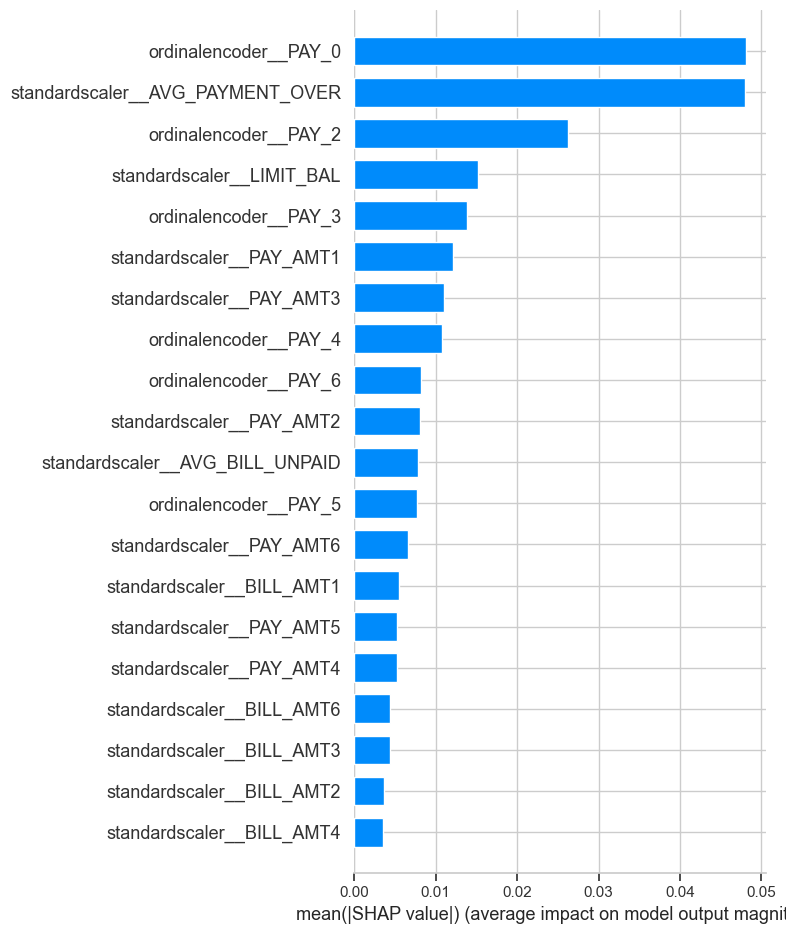

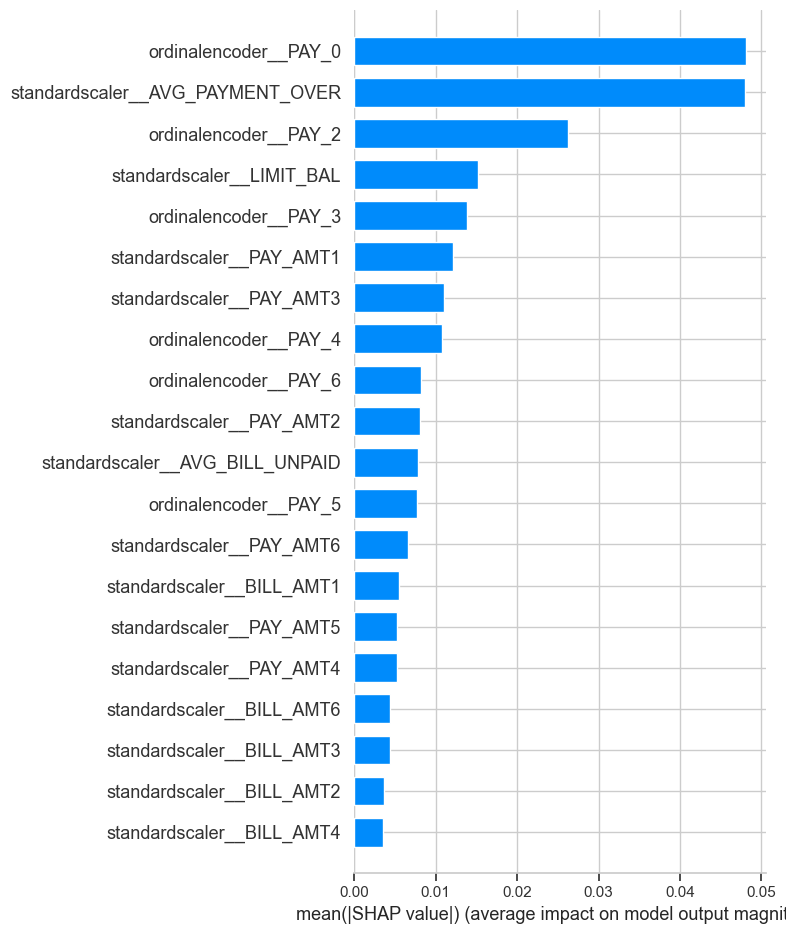

In [46]:
shap.summary_plot(shap_values_for_class_0, X_train_enc, plot_type="bar", title="Bar Graph for Model Feature Importance, Class 0")
shap.summary_plot(shap_values_for_class_1, X_train_enc, plot_type="bar", title="Bar Graph for Model Feature Importance, Class 0")

Whats good to see here is that our new feature made during feature transformations, AVG_PAY_OVER is very influential, indicating it is a good feature. Additionally, PAY_O is also very effective, but this is probably just be a result of taking a sample. LIMIT_BAL is also very helpful. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set

1. Tried best performing model on the test data and reported test scores.  

The highest performing model was the SVM with the best C of 3.0 and a gamma of 0.010

In [47]:
best_model = make_pipeline(preprocessor, SVC(C = 3.0, gamma = 0.010, probability = True))
best_model.fit(X_train, y_train)

# Calculate the accuracy
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)



Test Accuracy: 0.8188095238095238


The test accuracy compared to the model accuracy is very similar, which indicates out model generalizes to unseen data well. Additionally, it means that our model is not overfitting with the training data and agrees with the validation set. This also eliminates optimization bias.

In [48]:
# Select one from each class
ex1_idx = 1
ex2_idx = 10
print(y_test.iloc[ex1_idx])
print(y_test.iloc[ex2_idx])

0
1


In [49]:
shap_values_class_1 = shap.Explanation(
    values=test_shap_values[ex1_idx, :, 1],
    base_values=explainer.expected_value[1],
    data=X_test_enc.iloc[ex1_idx, :].values,
    feature_names=X_test_enc.columns
)

shap_values_class_0 = shap.Explanation(
    values=test_shap_values[ex1_idx, :, 0],
    base_values=explainer.expected_value[0],
    data=X_test_enc.iloc[ex1_idx, :].values,
    feature_names=X_test_enc.columns
)



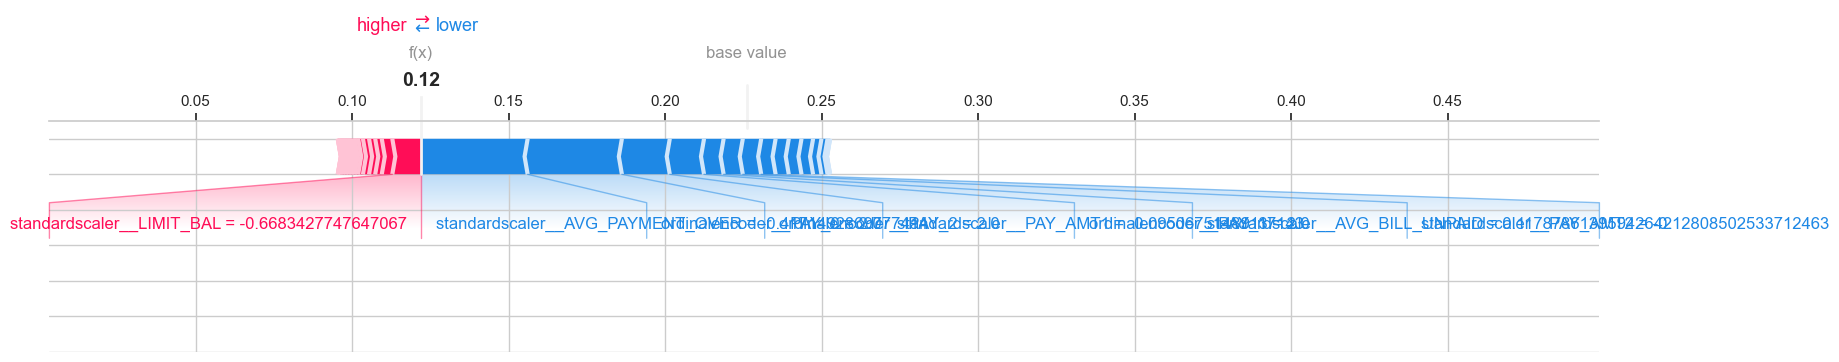

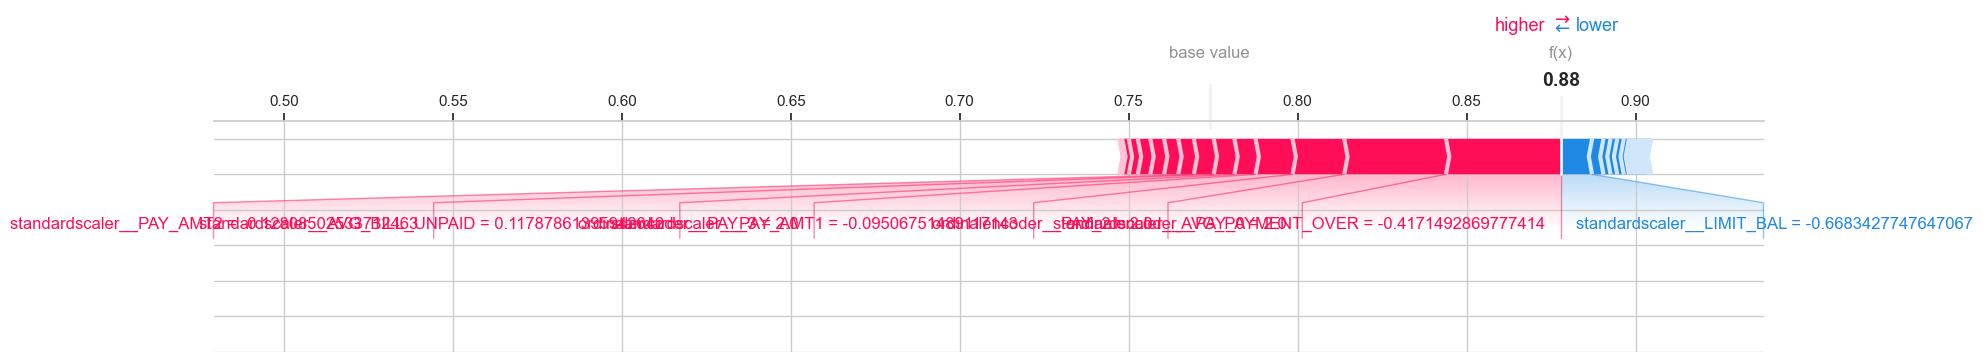

In [50]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class_1.values,
    shap_values_class_1.data,
    feature_names=shap_values_class_1.feature_names,
    matplotlib=True
)
shap.force_plot(
    explainer.expected_value[0],
    shap_values_class_0.values,
    shap_values_class_0.data,
    feature_names=shap_values_class_0.feature_names,
    matplotlib=True
)

These 2 graphs show the probabilities of each prediction, with one having chosen to be very small, indicating 0 for our target variable, and one being high, indicating 1 for our target variable. We can see that one is 10 percent and the other has a 90 percent probability. Furthermore, we can see which features contributed to the decision and how they did based on their values. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results

1. Table summarizing important results. 
2. Concluding remarks.
3. Some other ideas that I did not try but could potentially improve the performance/interpretability . 
3. Final test score

In [57]:
data = {
    "Model": ["Logistic Regression", "KNN", "SVC", "Random Forest"],
    "Score": [0.807, 0.813, 0.821, 0.818],
    "Best Hyperparameters": ["C = 1", "k-NN = 31", "C = 3.0, gamma = 0.01", "n_est = 200, max_feat = sqrt, max_depth = 10"]
}

results_df = pd.DataFrame(data)
print(results_df)

                 Model  Score                          Best Hyperparameters
0  Logistic Regression  0.807                                         C = 1
1                  KNN  0.813                                     k-NN = 31
2                  SVC  0.821                         C = 3.0, gamma = 0.01
3        Random Forest  0.818  n_est = 200, max_feat = sqrt, max_depth = 10


Some concluding remarks about this project are the many different ways to go about building a prediction model for this project. This is only scratching the surface of how much there is to this project and how deep machine learning models can go. There are more feature transformations I could have found, more classifiers to test, deeper hyperparameter optimization, dealing more with the class-imbalance. These are all things I may work on in the future, but for now I am satisfied with my final test score of 0.8188095238095238 with SVC classifier with tuned hyperparameters.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. My takeaway


I think the biggest takeaway from supervised machine learning is the balance one must have between having a good model and overfitting. Obviously a more complex model will generally do better, but what I find interesting is that how you make the model more complex is more important than how complex is actually is. A less complex model with better chosen attributes will fare much better than a more complex model with poorly chosen attributes. This is something I wish to continue to experiment with in the future in both this class and beyond.

<!-- END QUESTION -->

<br><br>

![](img/eva-well-done.png)